<a href="https://colab.research.google.com/github/Gooogr/Book_nlp_with_transformers/blob/main/ch4_multilingual_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will explore how a single transformer model called XLM-RoBERTa (introduced in Chapter 3) can be fine-tuned to perform named entity recognition (NER) across several languages.


In [2]:
# !pip install -qq transformers[sentencepiece] datasets seqeval

In [3]:
from datasets import load_dataset, DatasetDict
from collections import defaultdict,Counter 
from transformers import AutoTokenizer
import pandas as pd

For this case let’s assume that we want to perform NER for a customer based in
Switzerland, where there are four national languages (with English often serving as a
bridge between them). Let’s start by getting a suitable multilingual corpus for this
problem.

## Dataset

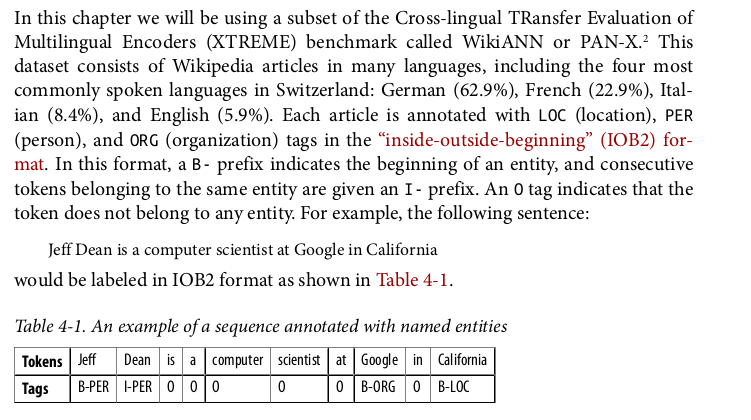

So, in order to create Swiss-like corpus we will sample diffenet language corpuses in the same ratio

In [4]:
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

In [5]:
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds: #train/validation/test
        panx_ch[lang][split] = (ds[split]
                                .shuffle(seed=0)
                                .select(range(int(frac * ds[split].num_rows))))

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 543.33it/s]


Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 625.14it/s]


Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 597.59it/s]


Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 609.55it/s]


In [6]:
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
              index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


By design we have more examples on German, so we will use it as starting point for the further zero-short learning for French, Italian and English.

In [7]:
# "de" sample example
element = panx_ch['de']['train'][0]
for key, value in element.items():
    print(f'{key}: {value}')

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [8]:
# And features are
for key, values in panx_ch['de']['train'].features.items():
    print(f'{key}: {values}')

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [10]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [11]:
panx_de = panx_ch['de'].map(create_tag_names)

In [12]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [13]:
# check sample
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


As a quick check that we don’t have any unusual imbalance in the tags, let’s calculate
the frequencies of each entity across each split:

In [14]:
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


Seems Ok.

## Multilingual Transformers

Our choice is XLM-RoBERTa

### Tokenization across different languages

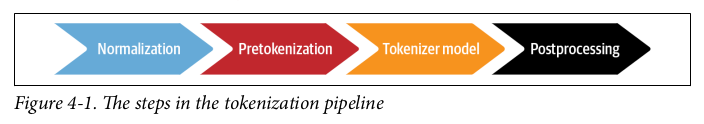

Instead of using a WordPiece tokenizer, XLM-R uses a tokenizer called SentencePiece that is trained on the raw text of all one hundred languages. To get a feel for how SentencePiece compares to WordPiece, let’s load the BERT and XLM-R tokenizers in the
usual way with Transformers:

In [15]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

In [16]:
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [17]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(bert_tokens)
print(xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


Here we see that instead of the `[CLS]` and `[SEP]` tokens that BERT uses for sentence classification tasks, XLM-R uses `<s>` and `<\s>` to denote the start and end of a sequence. These tokens are added in the final stage of tokenization, as we’ll see next.

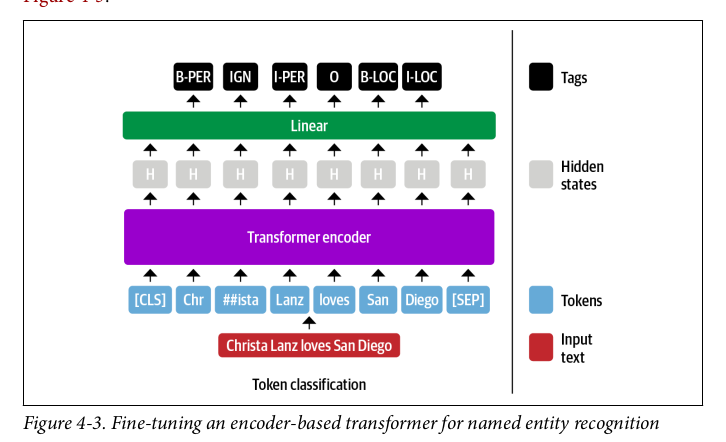

### The Anatomy of the Transformers Model Class

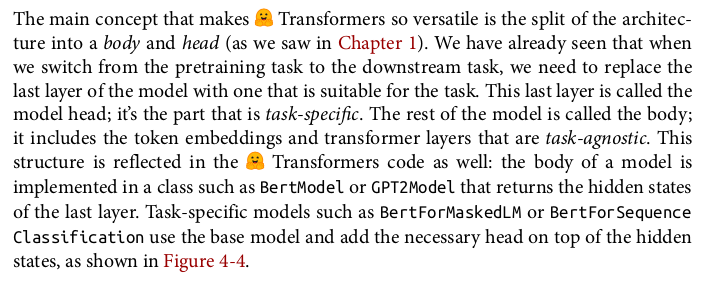

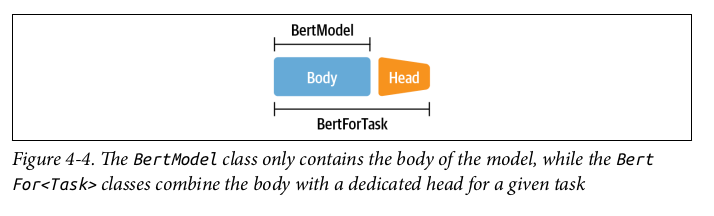

Creating a Custom Model for Token Classification

Let’s go through the exercise of building a custom token classification head for XLM-R. Since XLM-R uses the same model architecture as RoBERTa, we will use RoBERTa as the base model, but augmented with settings specific to XLM-R. 

**Note that this is
an educational exercise to show you how to build a custom model for your own task. For token classification, an XLMRobertaForTokenClassification class already exists that you can import from Transformers.** 
If you want, you can skip to the next section and simply use that one.

To get started, we need a data structure that will represent our XLM-R NER tagger. As
a first guess, we’ll need a configuration object to initialize the model and a `forward()` function to generate the outputs. Let’s go ahead and build our XLM-R class for token
classification:

In [18]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [19]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, 
                                     hidden_states=outputs.hidden_states, 
                                     attentions=outputs.attentions)


### Loading a Custom Model

In [20]:
from transformers import AutoConfig
from transformers import TrainingArguments
import torch

In [21]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [22]:
print(xlmr_model_name)

xlm-roberta-base


In [23]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name, 
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifie

In [25]:
# Check tokenizer
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [26]:
input_ids

tensor([[    0, 21763, 37456, 15555,  5161,     7,  2356,  5753,    38,     2]])

In [27]:
# Extract prediction samples
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [28]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,B-ORG,I-ORG,B-ORG,B-ORG,I-ORG,B-ORG,B-ORG,B-ORG,I-ORG


Unsurprisingly, our token classification layer with random weights leaves a lot to be
desired. Let’s fine-tune on some labeled data to make it better.

In [29]:
# Wrap previous steps for prediction generating
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [30]:
# Test run
tag_text(text, tags, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-ORG,B-ORG,I-ORG,B-ORG,B-ORG,I-ORG,B-ORG,B-ORG,B-ORG,I-ORG


### Tokenizing Texts for NER

Now that we’ve established that the tokenizer and model can encode a single example,
our next step is to tokenize the whole dataset so that we can pass it to the XLM-R
model for fine-tuning.

Let's start from the code sample and them wrap it in the function.

In [31]:
words, labels = de_example['tokens'], de_example['ner_tags']

In [32]:
tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)

tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In this example we can see that the tokenizer has split “Einwohnern” into two sub‐
words, “▁Einwohner” and “n”. Since we’re following the convention that only
“▁Einwohner” should be associated with the B-LOC label, we need a way to mask the
subword representations after the first subword. Fortunately, tokenized_input is a
class that contains a word_ids() function that can help us achieve this:

In [33]:
word_ids = tokenized_input.word_ids() # one word could be prolonged by several tokens

In [34]:
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Let’s set –100 as the label for the special tokens and the subwords we wish to mask during training:

In [35]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

In [36]:
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [37]:
# Wrap up all previous steps

def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

Tokenize our dataset

In [38]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [39]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

### Performance Measures

In [40]:
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
import numpy as np

from transformers import DataCollatorForTokenClassification
from transformers import Trainer

In [41]:
# Just minimal example
y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



Ok, we need a function that can take the outputs of the model
and convert them into the lists that seqeval expects.

In [42]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

### Fine-Tuning XLM-RoBERTa

In [43]:
num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(output_dir=model_name, 
                                  log_level="error", 
                                  num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size, 
                                  evaluation_strategy="epoch",
                                  save_steps=1e6, 
                                  weight_decay=0.01, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps, 
                                  push_to_hub=False)

F1 scorer

In [44]:
def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, 
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

The final step is to define a data collator so we can pad each input sequence to the
largest sequence length in a batch. Transformers provides a dedicated data collator
for token classification that will pad the labels along with the inputs:

In [45]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

Padding the labels is necessary because, unlike in a text classification task, the labels
are also sequences. One important detail here is that the label sequences are padded
with the value –100, which, as we’ve seen, is ignored by PyTorch loss functions.

We will train several models, so let's simplify model initializing step

In [46]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [47]:
trainer = Trainer(model_init=model_init, 
                  args=training_args,
                  data_collator=data_collator, 
                  compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

In [48]:
trainer.train()

/root/miniconda3/envs/idioms/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1575, training_loss=0.1561051747155568, metrics={'train_runtime': 415.264, 'train_samples_per_second': 90.882, 'train_steps_per_second': 3.793, 'total_flos': 863012377186080.0, 'train_loss': 0.1561051747155568, 'epoch': 3.0})

In [49]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


It works!

### Error Analysis

In [50]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]

    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
    labels.view(-1), reduction="none")
    
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    return {"loss":loss, "predicted_label": predicted_label}

In [51]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Parameter 'function'=<function forward_pass_with_label at 0x7ff1a26074c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Skip IGN labels (-100), map IDs with labels for readable format

In [52]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.018045183, 0.0, 0.029633885, 0.0214233...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [57]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(3)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.018,B-ORG,▁Ham
0,15,1,I-ORG,0.030,I-ORG,▁(
0,16104,1,I-ORG,0.021,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.025,I-ORG,▁)
1,56530,1,O,0.000,O,▁WE
1,83982,1,B-ORG,2.237,B-PER,▁Luz
1,10,1,I-ORG,2.520,I-PER,▁a


Let's check losses for each class

In [70]:
df_tokens.groupby("labels")[["loss"]].\
    agg(["count", "mean", "sum"]).\
    droplevel(level=0, axis=1).\
    sort_values(by="mean", ascending=False).\
    reset_index().\
    round(3).\
    T


,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.638,0.587,0.491,0.332,0.27,0.189,0.029
sum,1711.153,857.526,1875.091,1052.048,780.231,783.953,1280.053


We see theat the B-ORG has the highest loss, which means that this is the most difficult task for our model.

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [83]:
def plot_confusions_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

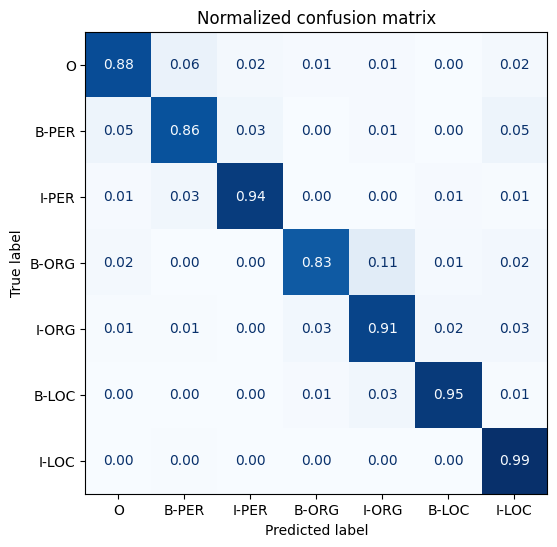

In [84]:
plot_confusions_matrix(df_tokens["labels"], df_tokens["predicted_label"], tags.names)

Model tends to confuse B-ORG and I-ORG

Ok, let's check samples with the highest loss

In [86]:
# Autor's approach, eyes bleeding iterrows
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, 
                               "preds": preds, "losses": losses}).T
        yield df_tmp

In [87]:
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

In [88]:
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,B-ORG,O,O,B-ORG,O,O,O,O,O,O,O
losses,0.00,0.00,4.94,0.00,0.00,0.00,11.06,10.03,8.04,7.79,8.59,0.00,7.95,8.59,0.00,8.74,8.64,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.89,0.00,0.00,5.83,8.11,8.62,6.90,0.00,8.43,8.91,7.67,5.24,4.22,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.23,5.35,5.78,0.00,5.72,0.00,5.68,0.00,5.48,5.45,5.56,5.69,5.46,5.32,0.00


Incorret true labels. For example Central African Republic was marked as person.

In [89]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.02,0.00,0.03,0.02,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.03,0.00,0.00,0.01,0.01,0.00,0.01,0.00


Also, we have relatively high loss for annotated parentheses, because in some samples they are marked as NER's (problem of automatically annotated data).

## Cross-Lingual Transfer